In [70]:
!pip install -q vizdoom==1.2.4 stable_baselines3==2.5.0 gymnasium==1.0.0 numpy==2.0.2 torch==2.5 tensorboard==2.18.0 tensorflow==2.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 64.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 78.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [71]:
import stable_baselines3
import vizdoom
import os
import gymnasium

In [3]:
cd studienarbeit

/kaggle/working/studienarbeit


In [64]:
%%writefile vizdoom_env.py
import gymnasium
import vizdoom as vzd
import numpy as np
from torch.utils.tensorboard import SummaryWriter

def create_vizdoom_env():
    game = vzd.DoomGame()
    game.load_config("scenarios/shooting/defend_the_line.cfg")
    game.set_depth_buffer_enabled(True) 
    game.set_labels_buffer_enabled(True)
    game.set_objects_info_enabled(True)

    class VizDoomGymEnv(gymnasium.Env):
        def __init__(self, game):
            self.game = game
            self.game.init()
            self.step_count = 0
            self.action_space = gymnasium.spaces.MultiBinary(len(self.game.get_available_buttons())) 
            self.observation_space = gymnasium.spaces.Box(
                low=0, 
                high=255, 
                shape=(self.game.get_screen_height(), self.game.get_screen_width(), 3),  
                dtype=np.uint8
            )
            self.kill_State = 0   
            self.health = 100
            self.damage_taken = 0
            self.HITCOUNT = 0
            self.episode_count = 0
            self.timesteps_survived = 0
            self.writer = SummaryWriter(f"custom_metrics/env_{self.episode_count}")
        
        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.game.new_episode()
            self.kill_State = 0
            state = self.game.get_state()
            return self._process_observation(state), {}

        #This is were all the reward shaping and custom metric collection happens
        def step(self, action):
            if self.game.is_episode_finished():
                return self._episode_done_response()

            # Directly checking for the test runs for how long agent stayed alive
            self.timesteps_survived += 1
            action = action.astype(int).tolist()
            reward = self.game.make_action(action)

            if self.game.get_state() is not None:
                game_vars = self.game.get_state().game_variables
                HITCOUNT, KILLCOUNT, DAMAGE_TAKEN, POS_X, POS_Y, AMMO = game_vars
                self._log_scalar("Game/PosX", POS_X)
                self._log_scalar("Game/PosY", POS_Y)

                living_reward = 0.01
                #Generally we just want him to live long and realize shooting enemies helps, while avoiding their shots increases his liftime
                reward += living_reward
                reward += (HITCOUNT - self.HITCOUNT) * 50 - DAMAGE_TAKEN * 0.1
                self.HITCOUNT = HITCOUNT

                if action[2]:  # move forward
                    reward -= 2
                # Since he had the full action space, for which this scenario was not intended, he kept moving forward. The idea of this penalty is that he should remain on his side of the map.
                # Value came by analyzing the map config file .wad
                if POS_X >= -465:
                    reward -= 10
                # Across all scenarios where shooting was involved, the agent had some kind of kink on shooting against walls. Up until now I can't explain why...but this penalizes him for doing so..
                if self._is_near_wall() and action[2]:
                    reward -= 100

            if self.game.is_episode_finished():
                return self._episode_done_response()

            state = self.game.get_state()
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8), reward, True, False, {}

            return self._process_observation(state), reward, False, False, {}

        def _episode_done_response(self):
            ammo = self.game.get_game_variable(vzd.SELECTED_WEAPON_AMMO)
            health = self.game.get_game_variable(vzd.HEALTH)
            outcome = 0 if health <= 0 else 1

            self._log_scalar("Game/Kills", self.HITCOUNT)
            self._log_scalar("Game/Outcome", outcome)
            self._log_scalar("Game/AmmoRemaining", ammo)
            self._log_scalar("Game/Health", health)
            self._log_scalar("Game/TimestepsSurvived", self.timesteps_survived)

            self.episode_count += 1
            self.kill_State = 0
            self.game.new_episode()

            return np.zeros(self.observation_space.shape, dtype=np.uint8), 0.0, True, False, {}

        def _log_scalar(self, tag, value):
            self.writer.add_scalar(tag, value, self.episode_count)

        def _is_near_wall(self):
            state = self.game.get_state()
            if state is None or state.depth_buffer is None:
                return False
            return np.min(state.depth_buffer) < 0  # WALL_THRESHOLD

        def _process_observation(self, state):
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8)
            return state.screen_buffer.copy()

        def render(self):
            state = self.game.get_state()
            return state.screen_buffer if state else np.zeros(self.observation_space.shape, dtype=np.uint8)

        def close(self):
            self.writer.close()
            self.game.close()

    return VizDoomGymEnv(game)


Overwriting vizdoom_env.py


In [74]:
%%writefile scenarios/shooting/defend_the_line.cfg

doom_scenario_path = defend_the_line.wad
doom_map = map01

# Rewards
death_penalty = 1

# Rendering options
screen_resolution = RES_160X120
screen_format = BGR24
render_hud = True
render_crosshair = True
render_weapon = True
render_decals = False
render_particles = False
window_visible = False

# make episodes start after 20 tics (after unholstering the gun)
episode_start_time = 14
episode_timeout = 1000

# Available buttons
available_buttons = 
	{ 
       	TURN_LEFT
        TURN_RIGHT
        ATTACK
        MOVE_LEFT
        MOVE_RIGHT
	}

# Game variables that will be in the state
# always keep HEALTH first (agent_health is referenced by index)
available_game_variables = 
	{
		HITCOUNT
        KILLCOUNT
		DAMAGE_TAKEN
		POSITION_X
		POSITION_Y
		SELECTED_WEAPON_AMMO
	}

mode = PLAYER
doom_skill = 4


Overwriting scenarios/shooting/defend_the_line.cfg


In [56]:
%%writefile ppo_pretraining.py
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv,make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 


# environment for each map
def make_env(map_name):
    """
    Utility function for creating a single environment.
    :param map_name: Name of the map configuration.
    :return: Callable function to create the environment.
    """
    return lambda: create_vizdoom_env(map=map_name)  # Ensure your `create_vizdoom_env` handles the `map` argument

if __name__ == '__main__':
    model_path = "ppo_vizdoom_model.zip"
    # Use SubprocVecEnv to handle multiple parallel environments
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=12)  # Pass a callable
    # envs = DummyVecEnv([make_env(map_name) for map_name in maps])

    print(os.path.exists(model_path))

    if os.path.exists(model_path):
        model = PPO.load(model_path, envs, verbose=1,tensorboard_log="./ppo_vizdoom_tensorboard/", device="cuda", ent_coef=0.1)
        model.set_env(env=envs)
    else:
        model = PPO("CnnPolicy",
            envs,
            n_steps=2048,
            learning_rate=5e-5,
            ent_coef=0.1,
            clip_range=0.2,
            gamma=0.95,
            gae_lambda=0.95,
            verbose=1,
            tensorboard_log="./ppo_vizdoom_tensorboard/",
            device="cuda")
    
    timesteps= 1000000
    model.learn(timesteps,tb_log_name=f"PPO")
    model.save(f"{model_path}")
    envs.close()

Overwriting ppo_pretraining.py


In [25]:
!python3 ppo_pretraining.py

2025-04-30 13:10:11.428412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746018611.454518     181 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746018611.462805     181 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
True
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Logging to ./ppo_vizdoom_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 263      |
|    ep_rew_mean     | -265     |
| time/              |          |
|    fps             | 537      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 24576    |
-

In [68]:
%%writefile testModel.py
#Used to run test on a specific model, gather the custom metrics and record the frames, meaning the game. To analyze what the agent actually did. 
import gymnasium
import cv2
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 
import time

# Environment setup
def make_env(map_name=None):
    return lambda: create_vizdoom_env()

if __name__ == '__main__':
    model_path = "archive/dtl_lvl5_1.zip"
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=1)
    model = PPO.load(model_path, env=envs, verbose=1)

    obs = envs.reset()

    frame = envs.envs[0].render()
    frame_shape = (frame.shape[1], frame.shape[0])  # (width, height)

    video_filename = "test_run.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(video_filename, fourcc, 30.0, frame_shape)

    for _ in range(4000):
        action, _ = model.predict(obs)
        obs, rewards, dones, _ = envs.step(action)

        frame = envs.envs[0].render()

        out.write(frame)

        if dones.any():
            obs = envs.reset()

        time.sleep(0.005)

    out.release()
    envs.close()
    print(f"Video saved as {video_filename}")

Overwriting testModel.py


In [75]:
!python3 testModel.py

2025-07-15 11:21:56.505920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752578516.528540     307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752578516.535372     307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Wrapping the env in a VecTransposeImage.
Video saved as test_run.mp4


# Generally across all scenarios we had to refactor the code and plot our own metrics plots, since the intial implementation using tensorboard didn't work in kaggle

# Extracting and plotting the tensorboard metrics for one specific model

In [ ]:
#Aggregate tensorboard metrics
ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []
for event_file in os.listdir("ppo_vizdoom_tensorboard/PPO_1/"):
    event_file_path = os.path.join("ppo_vizdoom_tensorboard/PPO_1/", event_file)
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag=="rollout/ep_len_mean": ep_len.append(v.simple_value)
            elif v.tag=="rollout/ep_rew_mean": ep_rew.append(v.simple_value)
            elif v.tag=="train/approx_kl": approx_kl.append(v.simple_value)
            elif v.tag=="train/explained_variance": explained.append(v.simple_value)
            elif v.tag=="train/loss": loss.append(v.simple_value)
            elif v.tag=="train/value_loss": value_loss.append(v.simple_value)

In [ ]:
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(15, 5))
axes[0].plot(ep_len)
axes[1].plot(ep_rew)
axes[2].plot(approx_kl)
axes[3].plot(explained)
axes[4].plot(loss)
axes[5].plot(value_loss)

# Extracting and plotting the full training progress for the whole curriculum training up until the extended ones. 

In [3]:
import os
import tensorflow as tf
from natsort import natsorted  # pip install natsort

# Root folder containing PPO_1/, PPO_2/, etc.
base_logdir = "ppo_vizdoom_tensorboard"

# Initialize metric lists
ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []

# Helper function to extract values
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained.append(v.simple_value)
            elif v.tag == "train/loss":
                loss.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss.append(v.simple_value)

# Traverse PPO_1, PPO_2, ... in natural order
for run_dir in natsorted(os.listdir(base_logdir)):
    full_run_path = os.path.join(base_logdir, run_dir)
    if os.path.isdir(full_run_path):
        for event_file in os.listdir(full_run_path):
            print(full_run_path)
            if "events.out.tfevents" in event_file:
                event_file_path = os.path.join(full_run_path, event_file)
                extract_metrics(event_file_path)

# You can now plot or further process the full training metrics
print("Total data points collected:")
print(f"Episode Length: {len(ep_len)}")
print(f"Episode Reward: {len(ep_rew)}")
print(f"Approx KL: {len(approx_kl)}")
print(f"Explained Variance: {len(explained)}")
print(f"Loss: {len(loss)}")
print(f"Value Loss: {len(value_loss)}")

ppo_vizdoom_tensorboard/dtl_lvl1
ppo_vizdoom_tensorboard/dtl_lvl2
ppo_vizdoom_tensorboard/dtl_lvl3
ppo_vizdoom_tensorboard/dtl_lvl4
ppo_vizdoom_tensorboard/dtl_lvl5.1
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
Total data points collected:
Episode Length: 105
Episode Reward: 105
Approx KL: 100
Explained Variance: 100
Loss: 100
Value Loss: 100


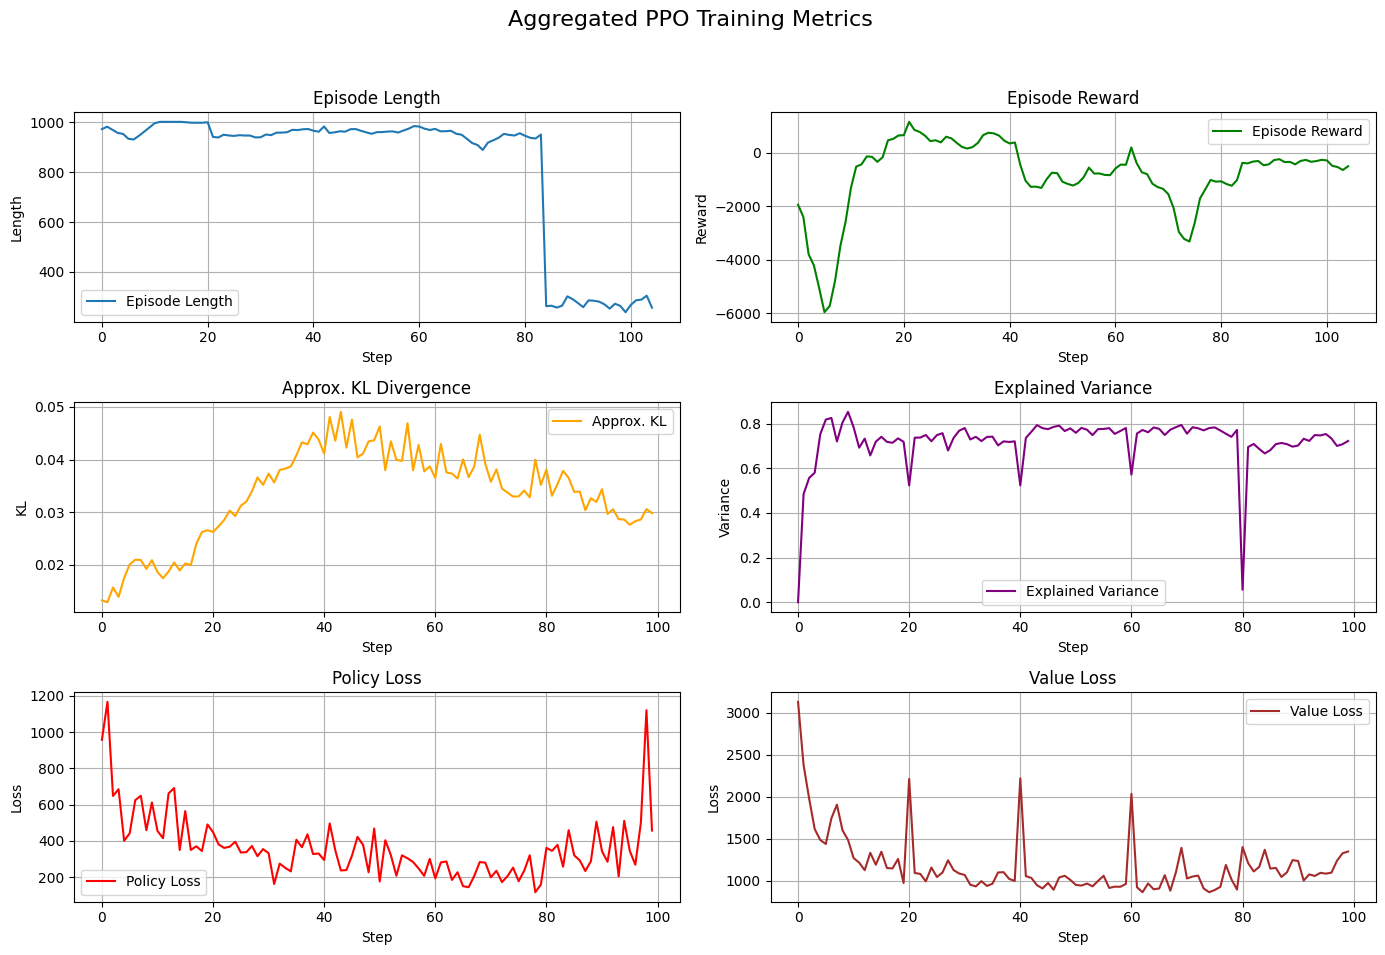

In [4]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Aggregated PPO Training Metrics", fontsize=16)

# Plot metrics
axs[0, 0].plot(ep_len, label="Episode Length")
axs[0, 0].set_title("Episode Length")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Length")

axs[0, 1].plot(ep_rew, label="Episode Reward", color='g')
axs[0, 1].set_title("Episode Reward")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(approx_kl, label="Approx. KL", color='orange')
axs[1, 0].set_title("Approx. KL Divergence")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("KL")

axs[1, 1].plot(explained, label="Explained Variance", color='purple')
axs[1, 1].set_title("Explained Variance")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Variance")

axs[2, 0].plot(loss, label="Policy Loss", color='red')
axs[2, 0].set_title("Policy Loss")
axs[2, 0].set_xlabel("Step")
axs[2, 0].set_ylabel("Loss")

axs[2, 1].plot(value_loss, label="Value Loss", color='brown')
axs[2, 1].set_title("Value Loss")
axs[2, 1].set_xlabel("Step")
axs[2, 1].set_ylabel("Loss")

# Improve layout
for ax in axs.flat:
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Extracting and plotting the full custom_metrics progress for the whole curriculum training up until the extended ones. 

Processing: dtl_lvl1
Processing: dtl_lvl2
Processing: dtl_lvl3
Processing: dtl_lvl4
Processing: dtl_lvl5.1


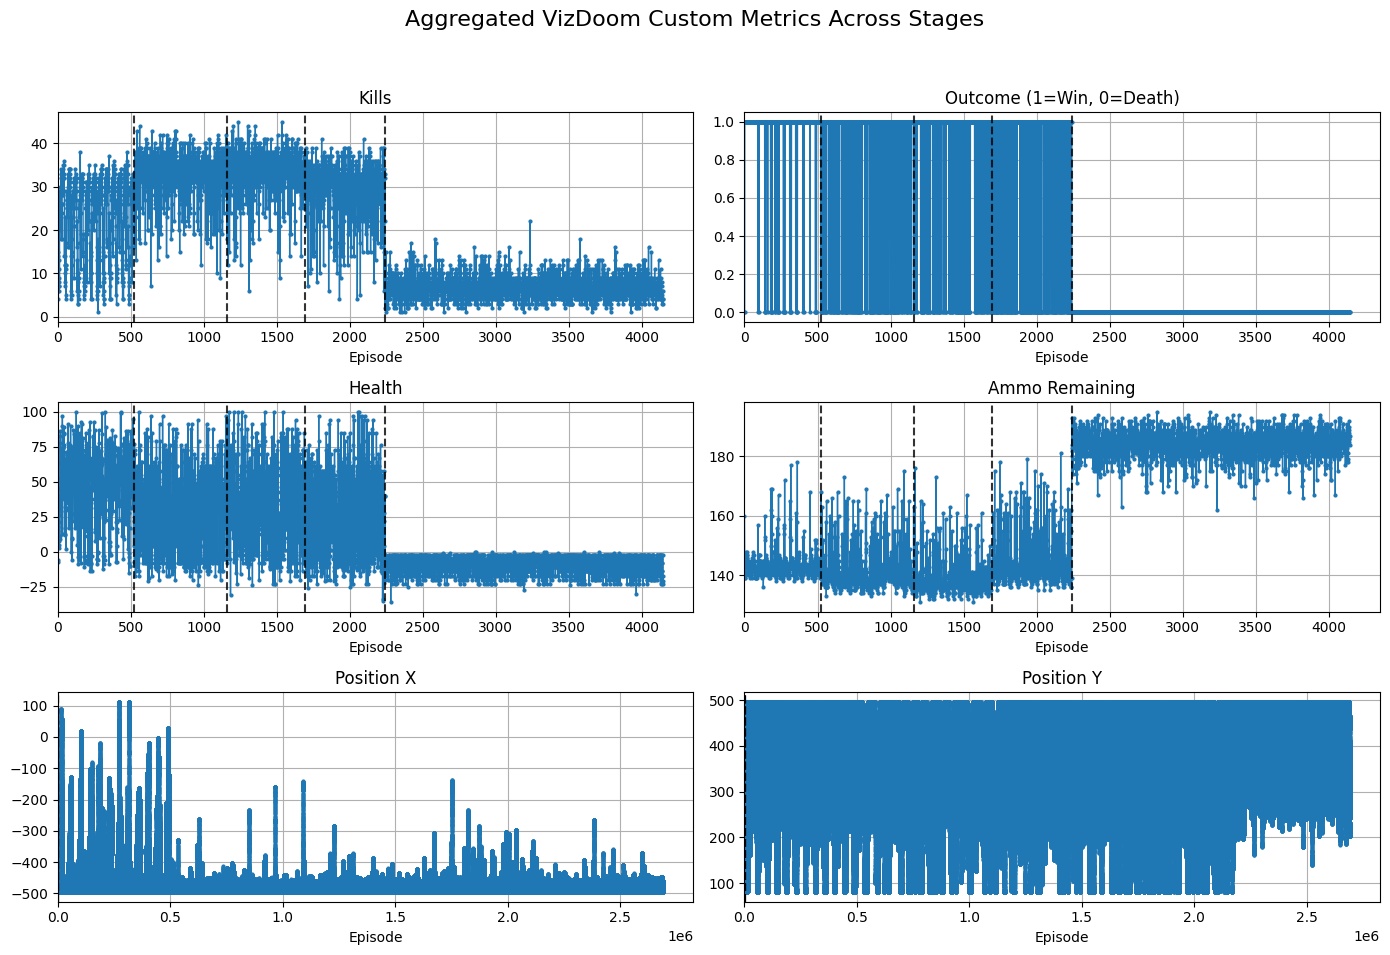

In [21]:
import tensorflow as tf
import os
from natsort import natsorted
import matplotlib.pyplot as plt

# Aggregated lists
kills, outcomes = [], []
health, ammo = [], []
pos_x, pos_y = [], []
stage_boundaries = []
stage_names = []

# Base directory
base_dir = "custom_metrics/plot"

# Traverse subfolders in natural order
for run_name in natsorted(os.listdir(base_dir)):
    run_path = os.path.join(base_dir, run_name)
    if not os.path.isdir(run_path):
        continue  # Skip files in base_dir

    print(f"Processing: {run_name}")
    local_kills, local_outcomes = [], []
    local_health, local_ammo = [], []
    local_pos_x, local_pos_y = [], []

    for event_file in os.listdir(run_path):
        event_file_path = os.path.join(run_path, event_file)
        if not os.path.isfile(event_file_path):
            continue  # Skip subfolders like "backup/"
        if "tfevents" not in event_file:
            continue  # Skip unrelated files

        try:
            for summary in tf.compat.v1.train.summary_iterator(event_file_path):
                for v in summary.summary.value:
                    tag = v.tag
                    val = v.simple_value
                    if tag == "Game/Kills":
                        local_kills.append(val)
                    elif tag == "Game/Outcome":
                        local_outcomes.append(val)
                    elif tag == "Game/Health":
                        local_health.append(val)
                    elif tag == "Game/AmmoRemaining":
                        local_ammo.append(val)
                    elif tag == "Game/PosX":
                        local_pos_x.append(val)
                    elif tag == "Game/PosY":
                        local_pos_y.append(val)
        except Exception as e:
            print(f"⚠️  Skipping unreadable file: {event_file_path} ({e})")

    # Append metrics
    kills.extend(local_kills)
    outcomes.extend(local_outcomes)
    health.extend(local_health)
    ammo.extend(local_ammo)
    pos_x.extend(local_pos_x)
    pos_y.extend(local_pos_y)

    # Track stage boundary
    if kills:
        stage_boundaries.append(len(kills))
        stage_names.append(run_name)

# Plot all metrics
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Aggregated VizDoom Custom Metrics Across Stages", fontsize=16)

plot_config = [
    (kills, "Kills", axs[0, 0]),
    (outcomes, "Outcome (1=Win, 0=Death)", axs[0, 1]),
    (health, "Health", axs[1, 0]),
    (ammo, "Ammo Remaining", axs[1, 1]),
    (pos_x, "Position X", axs[2, 0]),
    (pos_y, "Position Y", axs[2, 1]),
]

for data, title, ax in plot_config:
    ax.plot(data, marker='o', markersize=2, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Episode")
    ax.grid(True)
    ax.set_xlim(left=0)

    for boundary in stage_boundaries[:-1]:  # Skip last boundary (end of data)
        ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Extracting and plotting the full tensorboard training progress for the whole curriculum training up until the extended ones, including vertical lines at the transitions between level increases

Processing: dtl_lvl1
Processing: dtl_lvl2
Processing: dtl_lvl3
Processing: dtl_lvl4
Processing: dtl_lvl5.1
Processing: extended


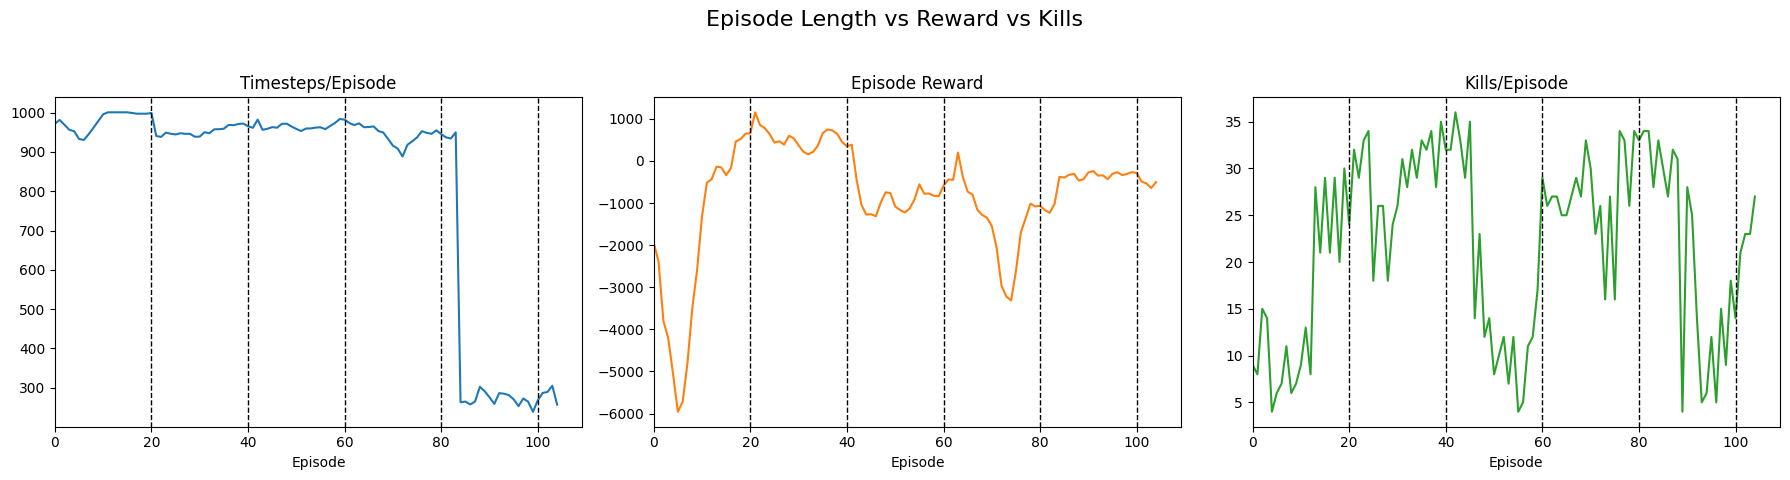

In [5]:
import os
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt

def extract_metrics(event_file_path):
    """Extracts relevant training metrics from a TensorBoard event file."""
    ep_len, ep_rew = [], []
    approx_kl, explained = [], []
    loss, value_loss = [], []

    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            tag = v.tag
            val = v.simple_value
            if tag == "rollout/ep_len_mean":
                ep_len.append(val)
            elif tag == "rollout/ep_rew_mean":
                ep_rew.append(val)
            elif tag == "train/approx_kl":
                approx_kl.append(val)
            elif tag == "train/explained_variance":
                explained.append(val)
            elif tag == "train/loss":
                loss.append(val)
            elif tag == "train/value_loss":
                value_loss.append(val)

    return ep_len, ep_rew, approx_kl, explained, loss, value_loss

def load_all_metrics(base_logdir):
    """
    Loads and returns all PPO metrics from TensorBoard event files.
    Publicly exposes the metrics via named dictionary keys.
    """
    metrics = {
        "ep_len": [],
        "ep_rew": [],
        "approx_kl": [],
        "explained": [],
        "loss": [],
        "value_loss": [],
        "stage_boundaries": [],
        "stage_names": []
    }

    for run_dir in natsorted(os.listdir(base_logdir)):
        full_run_path = os.path.join(base_logdir, run_dir)
        if not os.path.isdir(full_run_path):
            continue

        print(f"Processing: {run_dir}")
        event_files = [f for f in os.listdir(full_run_path) if "events.out.tfevents" in f]

        local_ep_len, local_ep_rew = [], []
        local_kl, local_expl = [], []
        local_loss, local_value_loss = [], []

        for ef in event_files:
            ef_path = os.path.join(full_run_path, ef)
            lel, ler, lakl, lexp, lloss, lval_loss = extract_metrics(ef_path)
            local_ep_len.extend(lel)
            local_ep_rew.extend(ler)
            local_kl.extend(lakl)
            local_expl.extend(lexp)
            local_loss.extend(lloss)
            local_value_loss.extend(lval_loss)

        # Append to global metrics
        metrics["ep_len"].extend(local_ep_len)
        metrics["ep_rew"].extend(local_ep_rew)
        metrics["approx_kl"].extend(local_kl)
        metrics["explained"].extend(local_expl)
        metrics["loss"].extend(local_loss)
        metrics["value_loss"].extend(local_value_loss)

        if metrics["ep_len"]:
            metrics["stage_boundaries"].append(len(metrics["ep_len"]))
            metrics["stage_names"].append(run_dir)

    return metrics

def plot_length_reward_kills(ep_len, ep_rew, kills):
    min_len = min(len(ep_len), len(ep_rew), len(kills))
    x = list(range(min_len))

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Episode Length vs Reward vs Kills", fontsize=16)

    axs[0].plot(x, ep_len[:min_len], color='tab:blue')
    axs[0].set_title("Timesteps/Episode")
    axs[0].set_xlabel("Episode")
    axs[0].set_xlim(left=0)  # Force x-axis to start at 0

    axs[1].plot(x, ep_rew[:min_len], color='tab:orange')
    axs[1].set_title("Episode Reward")
    axs[1].set_xlabel("Episode")
    axs[1].set_xlim(left=0)  # Force x-axis to start at 0

    axs[2].plot(x, kills[:min_len], color='tab:green')
    axs[2].set_title("Kills/Episode")
    axs[2].set_xlabel("Episode")
    axs[2].set_xlim(left=0)  # Force x-axis to start at 0

    # Add vertical lines at multiples of 20
    for ax in axs:
        for x_val in range(20, min_len, 20):
            ax.axvline(x=x_val, color='black', linestyle='--', linewidth=1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    
if __name__ == "__main__":
    base_logdir = "ppo_vizdoom_tensorboard"
    metrics = load_all_metrics(base_logdir)

    # You must load or define kills data separately here.
    # For example, if you have it as a list:

plot_length_reward_kills(metrics["ep_len"], metrics["ep_rew"], kills)
